# ***Voorspellen van Verhuuraantallen*** 

Teamleden:
- Busse Heemskerk
- Declan van den Hoek
- Isa Dijkstra

In dit notebook worden er, aan de hand van een train dataset, verschillende Machine Learning modellen opgesteld om de meest accurate manier te vinden om diabetes te voorspellen. Voor het project hebben we gewerkt in [GitHub](https://github.com/BJHeemskerk/MachineLearning), om makkelijk de bestanden te delen.

## ***Inhoudsopgave*** <a name='begin'></a>

1. [H1: Explorative Data Analysis](#h1)

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_test = pd.read_csv('test.csv', sep = ',')
data_train = pd.read_csv('train.csv', sep = ',')

In [9]:
data_train.head()

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1


## **H1: Explorative Data Analysis**<a name='h1'></a>

De minimale vereisten voor Machine Learning met Scikit Learn zijn:

- De data mag geen missende waardes hebben
- De data moet bestaan uit numerieke waardes
- De data moet in een dataframe staan

Omdat de data is ingelezen via Pandas staat het al in een Pandas DataFrame, hierdoor kan gebruik gemaakt worden van de .info() methode van DataFrames om te kijken naar missende waarden en de datatypen.

In [10]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_hour   16637 non-null  object 
 1   holiday     16637 non-null  int64  
 2   weathersit  16637 non-null  int64  
 3   temp        16637 non-null  float64
 4   atemp       16637 non-null  float64
 5   hum         16637 non-null  float64
 6   windspeed   16637 non-null  float64
 7   cnt         16637 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 1.0+ MB


In [11]:
data_train.describe()

,holiday,weathersit,temp,atemp,hum,windspeed,cnt
count,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,0.028671,1.415580,0.504745,0.482608,0.624756,0.190310,190.477009
std,0.166885,0.637298,0.192369,0.171557,0.193227,0.121915,182.026755
min,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,41.000000
50%,0.000000,1.000000,0.520000,0.500000,0.620000,0.194000,143.000000
75%,0.000000,2.000000,0.660000,0.621200,0.780000,0.253700,282.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


### ***Time-Series visualisaties***



In [54]:
def seizoen(maand, dag):
    """
    Een functie die op basis van maand en dag de seizoenen
    kan bepalen in een kolom.

    Parameters:
    ----------
    maand : str
        De kolomnaam met de maanden

    dag : str
        De kolomnaam met de dagnummers

    Returns:
    ----------
    int
        Een nummer die correspondeerd met het seizoen
    """

    if (maand == 3 and dag >= 21) or (maand > 3 and maand < 6) or (maand == 6 and dag < 21):
        return 2 # Lente
    elif (maand == 6 and dag >= 21) or (maand > 6 and maand < 9) or (maand == 9 and dag < 21):
        return 3 # Zomer
    elif (maand == 9 and dag >= 21) or (maand > 9 and maand < 12) or (maand == 12 and dag < 21):
        return 4 # Herfst
    else:
        return 1 # Winter

def data_voorbereiding(base_df, dt_kol):
    """
    Een functie om een csv in te lezen en verschillende
    toepassingen uit te voeren op aanwezige timeseries
    data.

    Parameters:
    ----------
    base_df : pd.DataFrame
        De naam van het dataframe waar de extra
        timeseries kolommen worden gemaakt.
    
    dt_kol : str
        De naam van de kolom met de Timeseries data.

    Returns:
    ----------
    df : pd.DataFrame
        Een pandas.DataFrame waarin verschillende extra
        kolommen zijn toegevoegd waarin timeseries is
        toegepast.
    """
    
    # Omzetten van date_hour naar datetime
    df = base_df.copy()
    df[f'{dt_kol}'] = pd.to_datetime(df[f'{dt_kol}'])

    # Voeg nieuwe kolommen toe
    df['Jaar'] = df[f'{dt_kol}'].dt.year
    df['Maand'] = df[f'{dt_kol}'].dt.month
    df['Week'] = df[f'{dt_kol}'].dt.isocalendar().week
    df['Dag'] = df[f'{dt_kol}'].dt.day
    df['Uur'] = df[f'{dt_kol}'].dt.hour

    # Toevoegen seizoenen
    df['Seizoen'] = df.apply(lambda row: seizoen(row['Maand'], row['Dag']), axis=1)

    return df

In [55]:
df = data_voorbereiding(data_train, 'date_hour')
df.head()

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,Jaar,Maand,Week,Dag,Uur,Seizoen
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16,2011,1,52,1,0,1
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40,2011,1,52,1,1,1
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32,2011,1,52,1,2,1
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13,2011,1,52,1,3,1
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1,2011,1,52,1,4,1


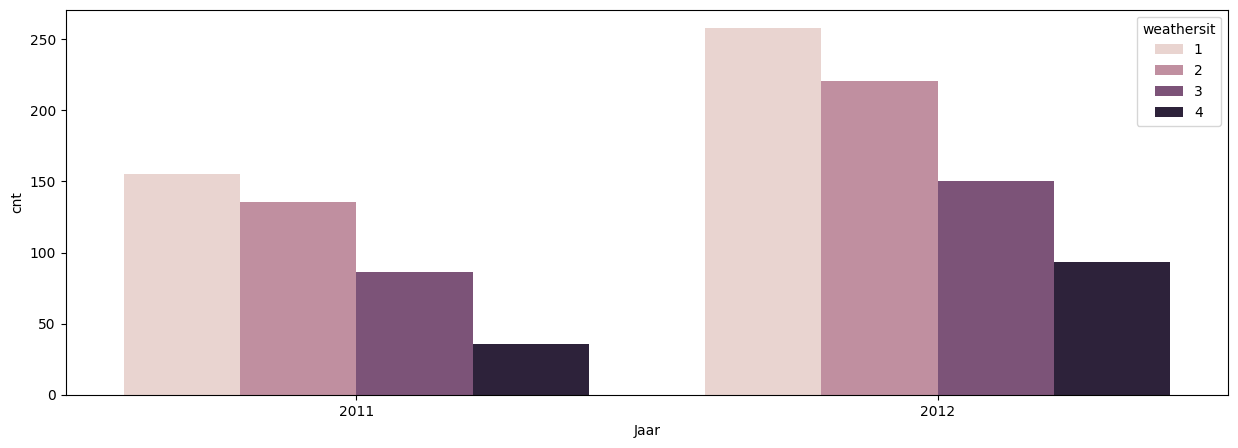

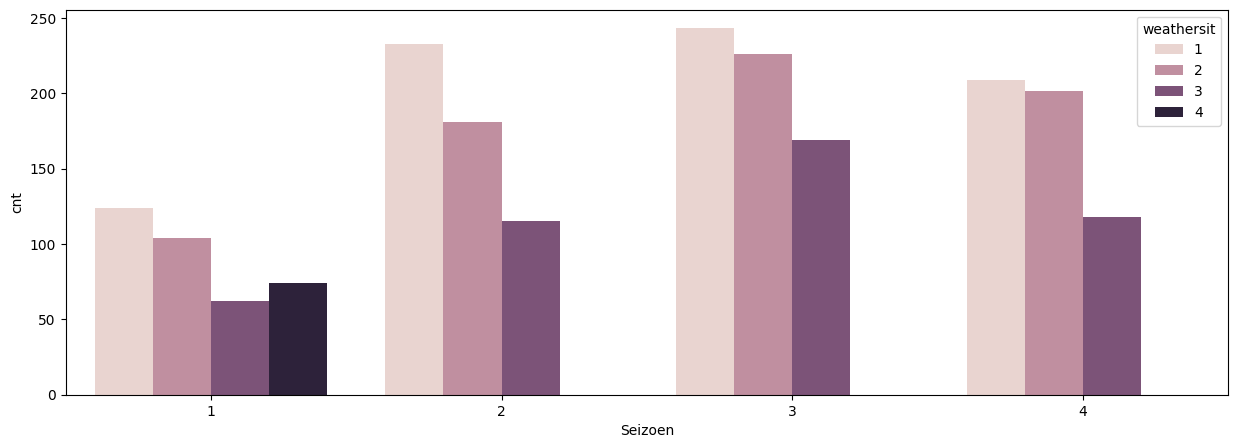

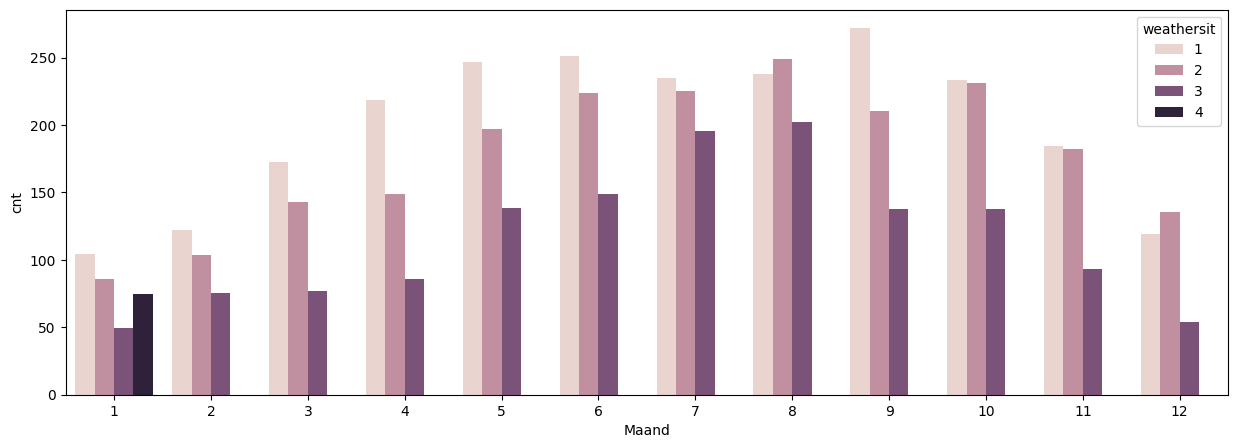

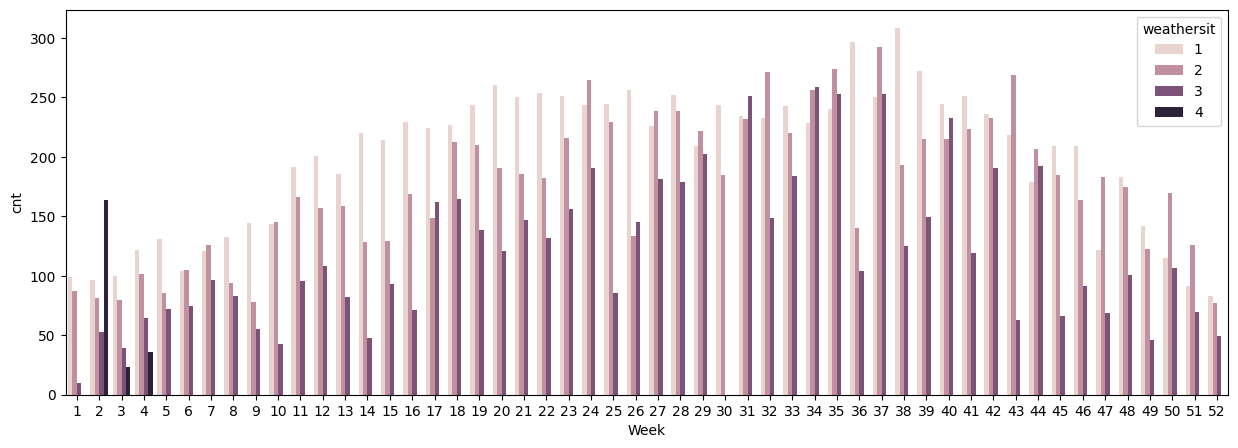

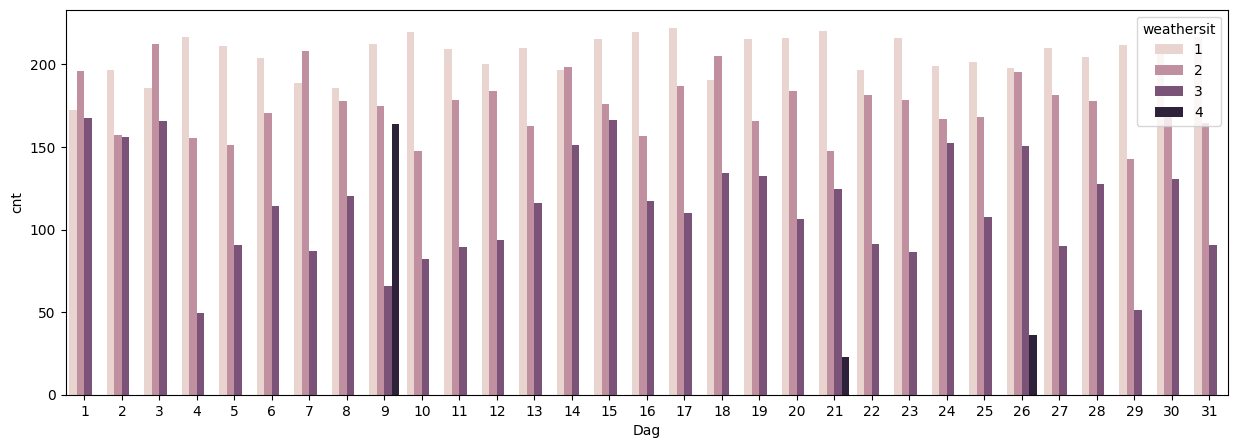

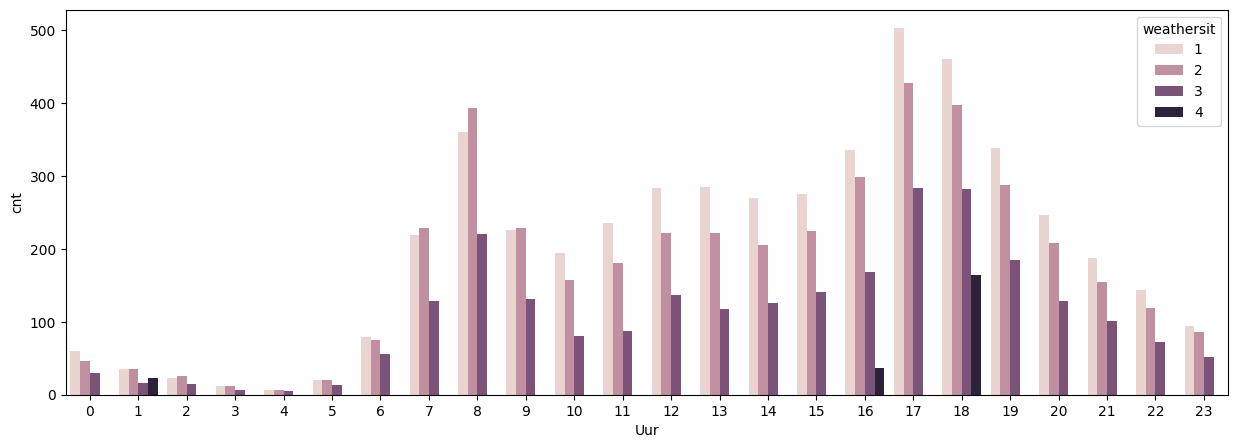

In [58]:
tijden = ['Jaar', 'Seizoen', 'Maand', 'Week', 'Dag', 'Uur']

for time in tijden:
    plt.subplots(figsize=(15,5))
    sns.barplot(data=df, x=time, y='cnt',
                errorbar=None, hue='weathersit')
    plt.show()

Zoals hierboven te zien is, zijn er in 2012 en in de lente/zomer maanden meer verhuursaantallen. Dit is nog meer benadrukt door de hue instelling van de grafiek. Voor weersituatie 1 zijn er over het algemeen hogere aantallen en hoe verder je die trap opgaat hoe minder het er worden.

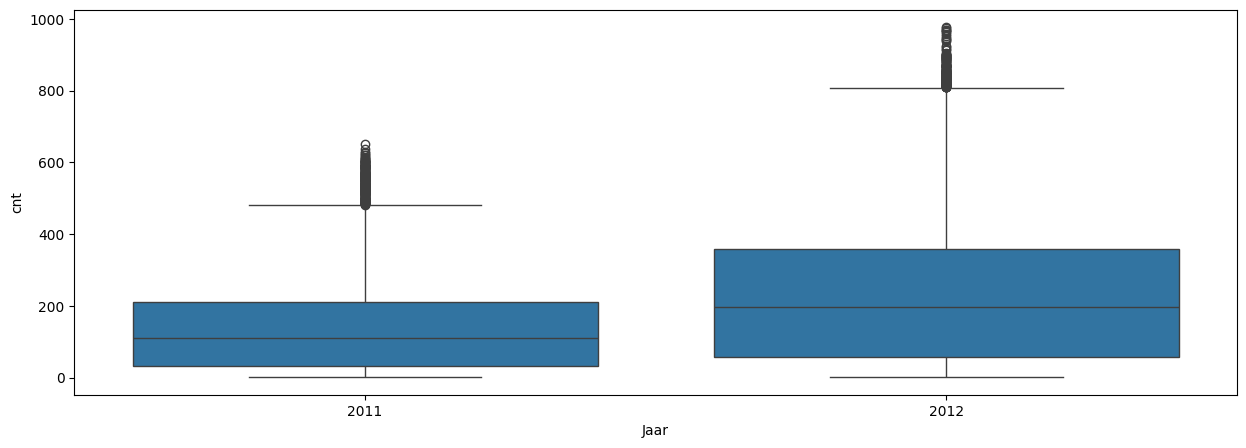

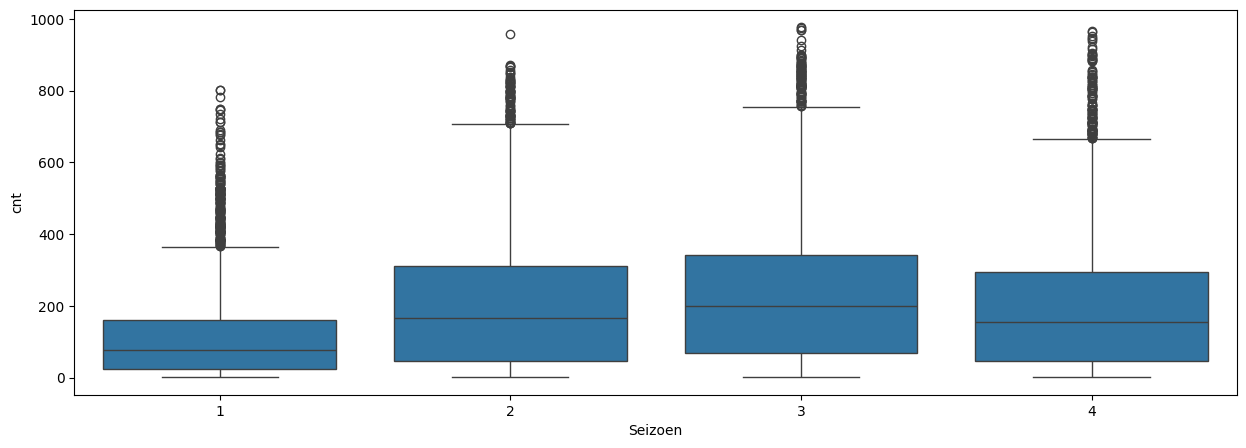

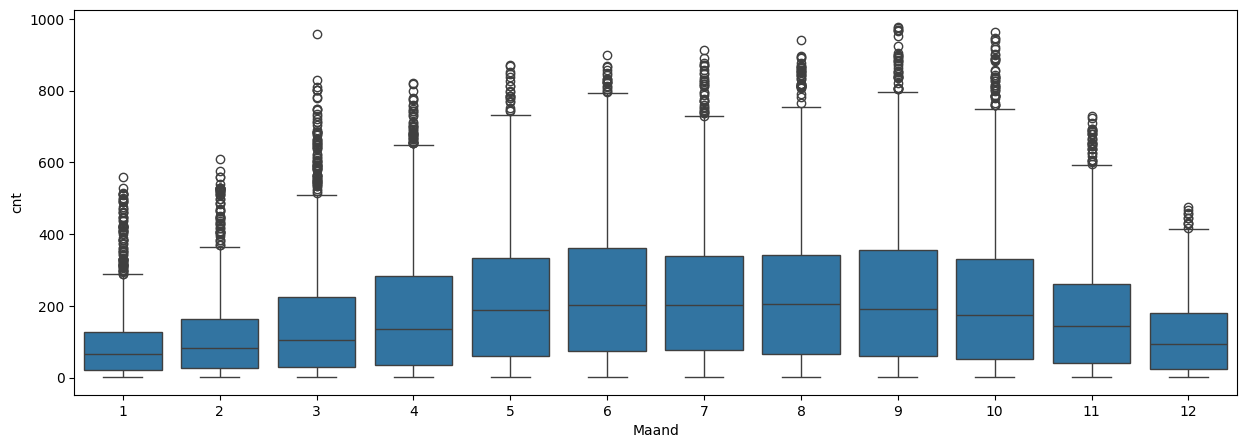

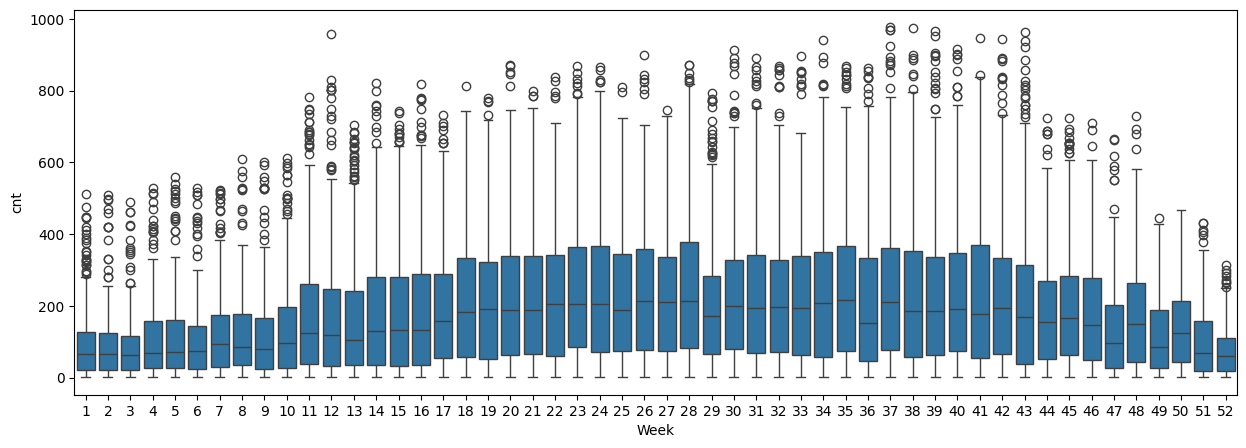

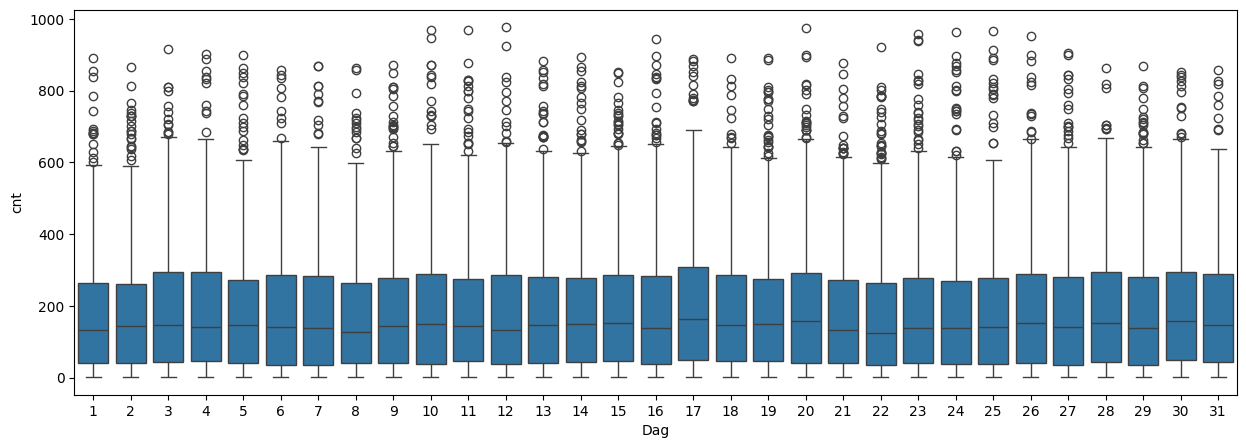

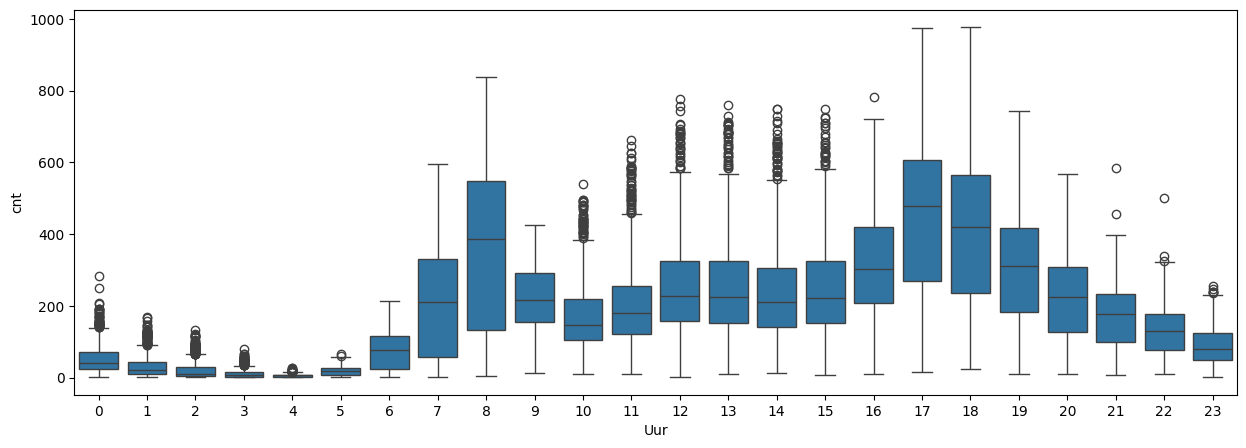

In [61]:
tijden = ['Jaar', 'Seizoen', 'Maand', 'Week', 'Dag', 'Uur']

for time in tijden:
    plt.subplots(figsize=(15,5))
    sns.boxplot(data=df, x=time, y='cnt')
    plt.show()

Bij de boxplots is duidelijk te zien dat de mediaan in het midden van het jaar hoger ligt dan in het begin en einde van het jaar, wel zijn er elke keer veel uitschieters. Hieruit is op te maken dat er een algemene lagere verhuur kan worden verwacht met de plotselinge uitschieters elke week.

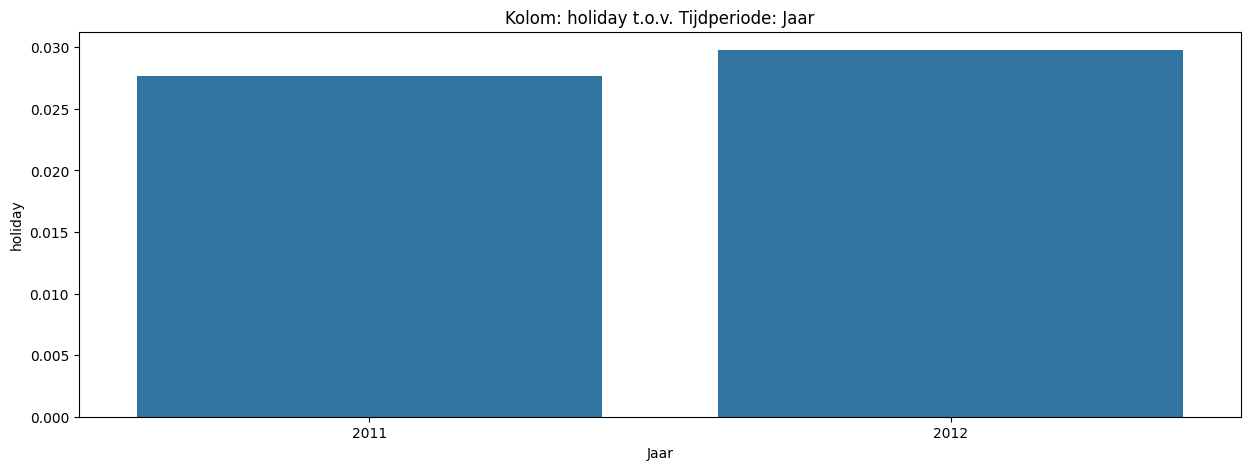

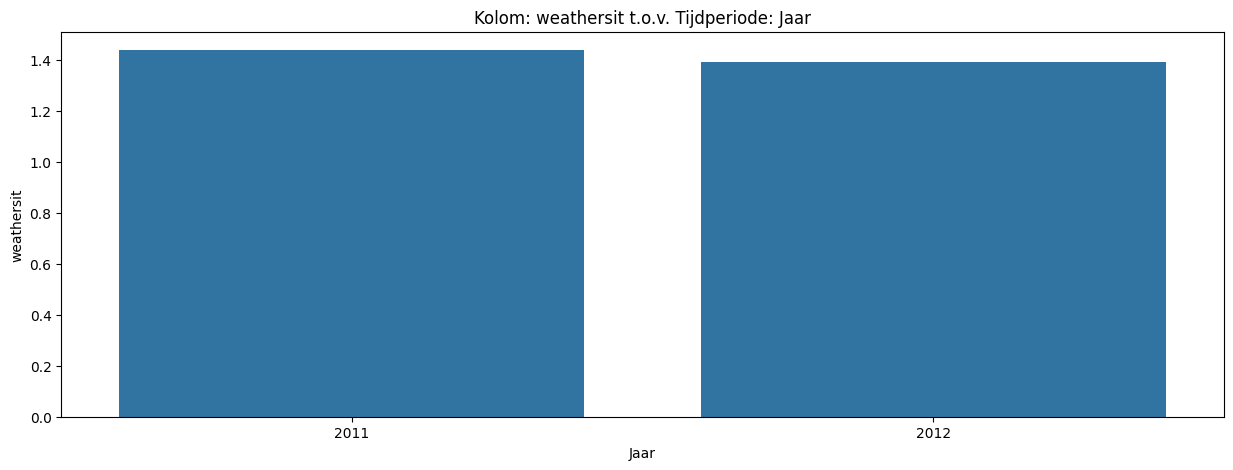

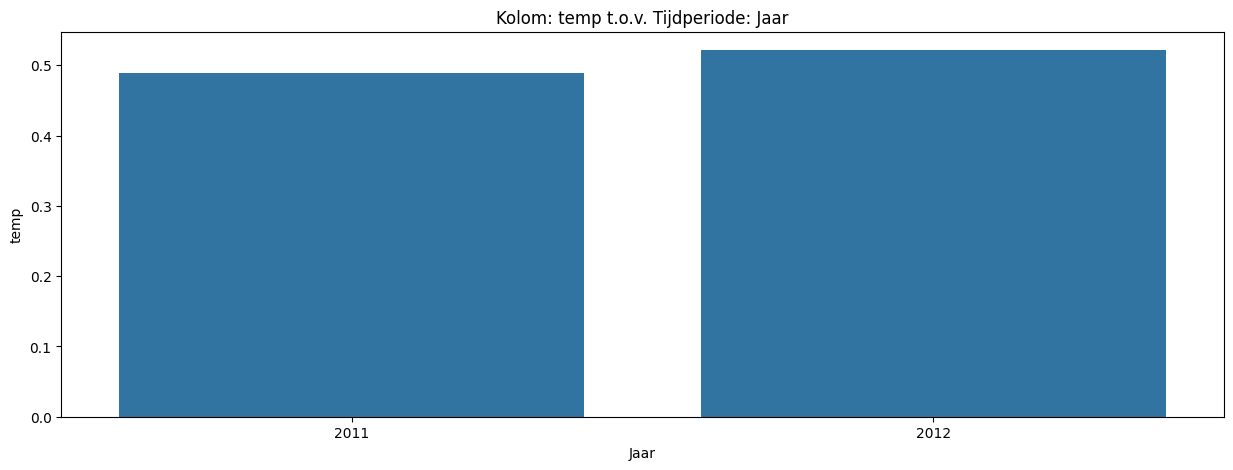

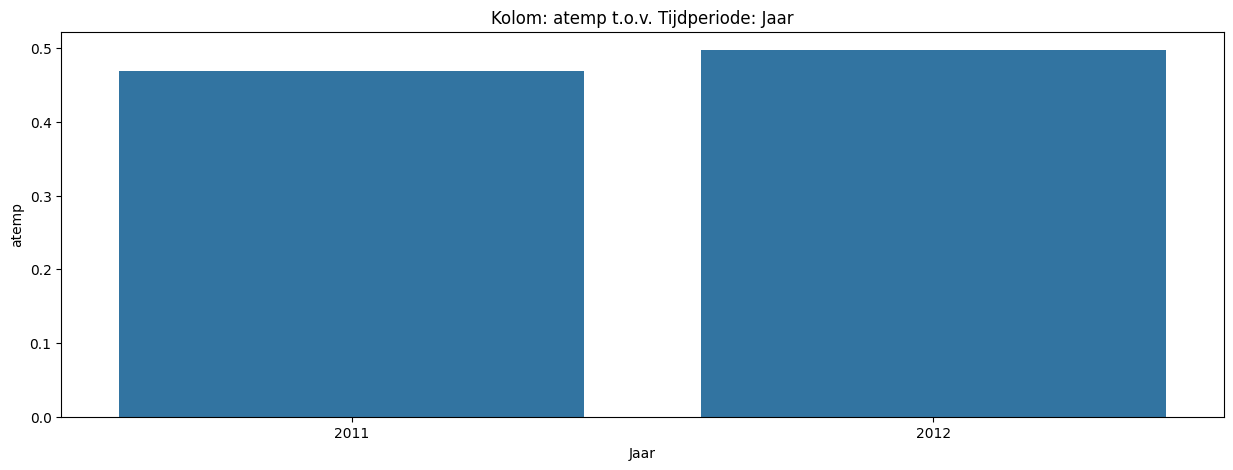

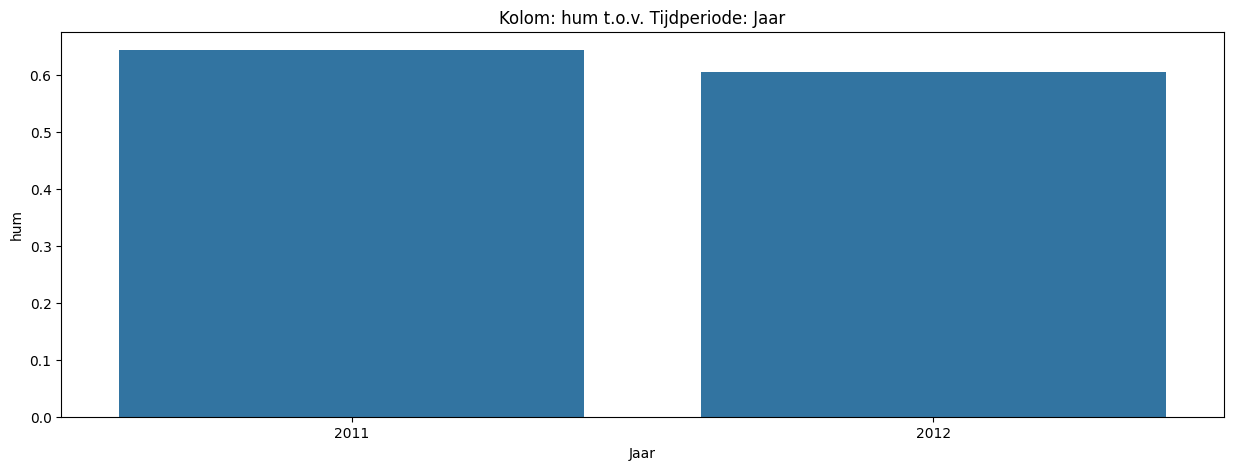

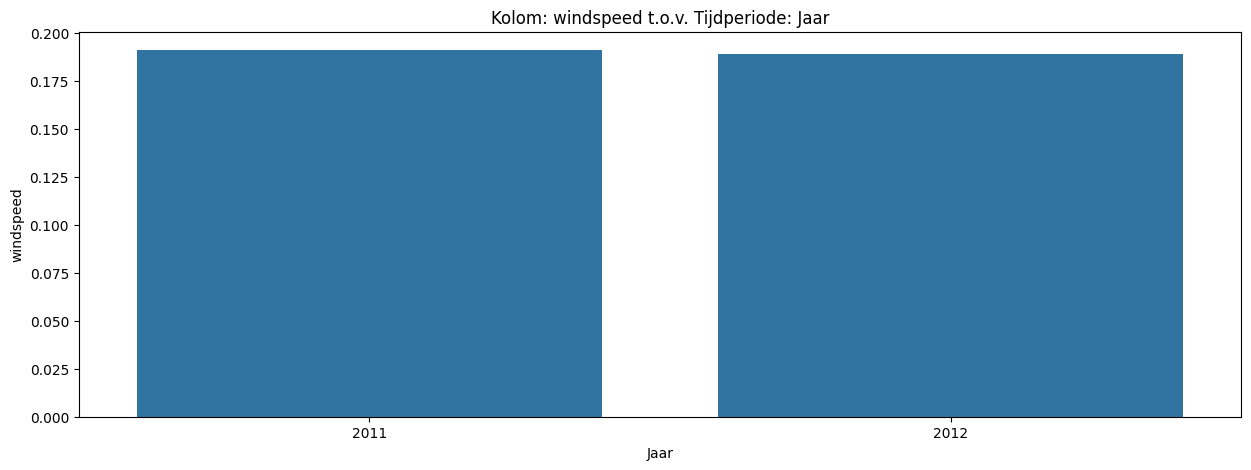

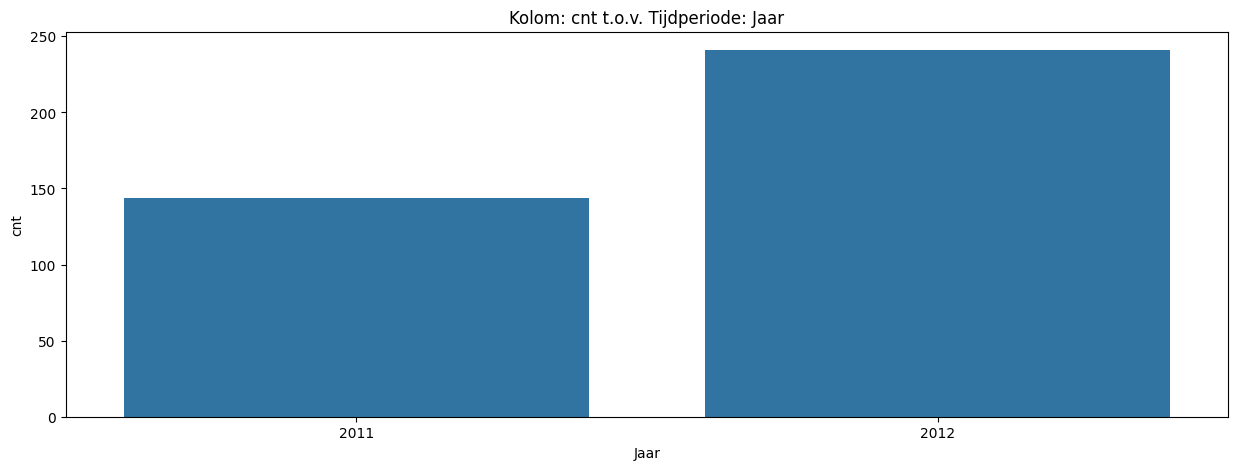

In [74]:
kolommen = ['holiday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']

for col in kolommen:
    plt.subplots(figsize=(15,5))
    sns.barplot(data=df, x='Jaar', y=col,
                errorbar=None)
    plt.title(f'Kolom: {col} t.o.v. Tijdperiode: Jaar')
    plt.show()

Er valt per jaar weinig verschil in de waarden te vinden. Dit verschil kan ook komen door het niet hebben van de maand december in het jaar 2012. Wat wel opvalt is het hoge verschil in verhuursaantallen tussen de jaren.

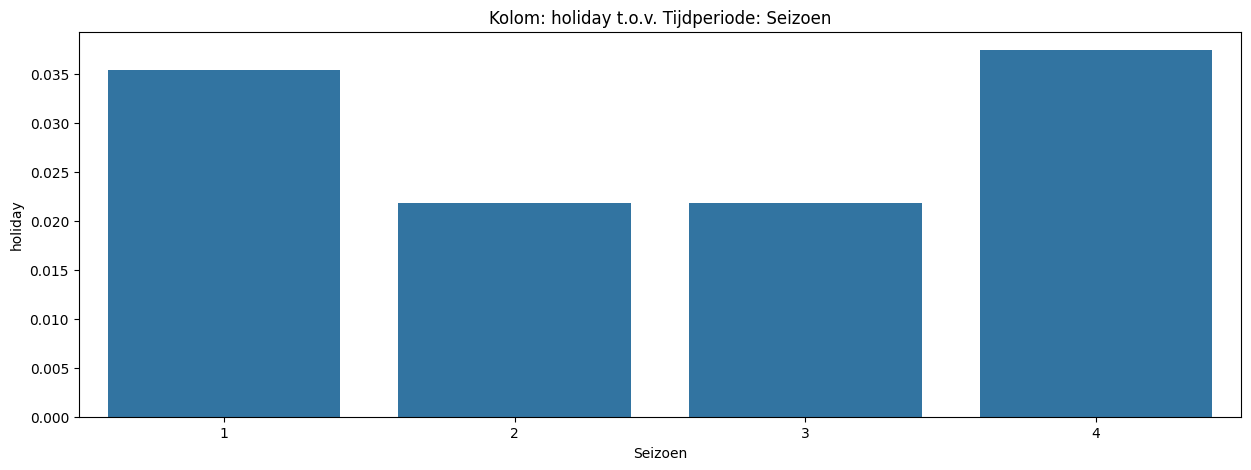

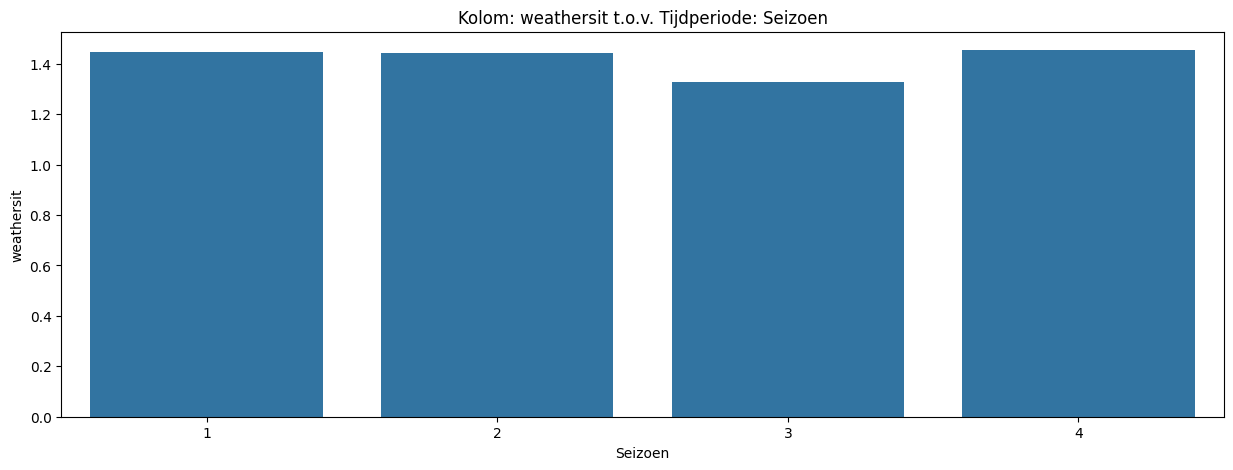

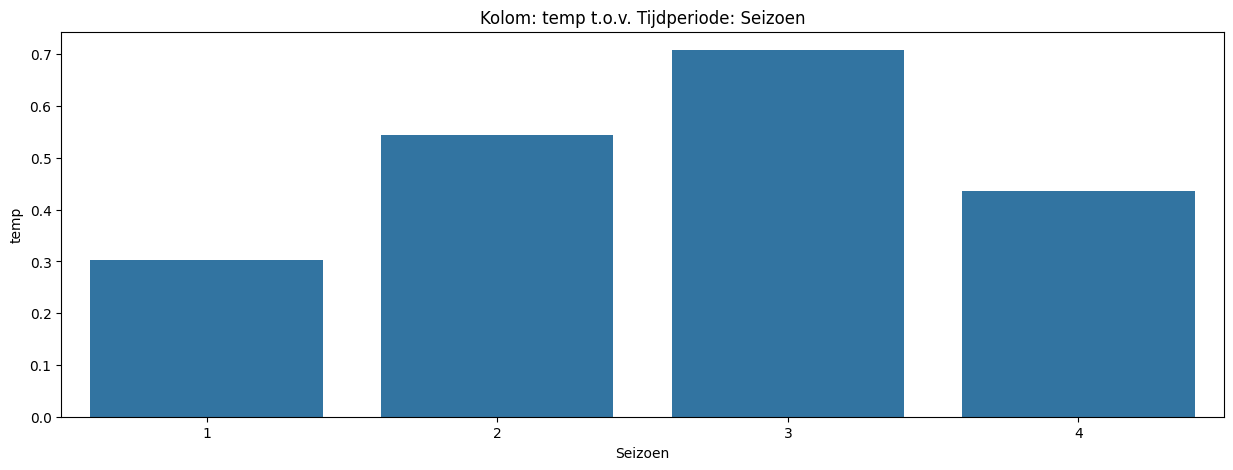

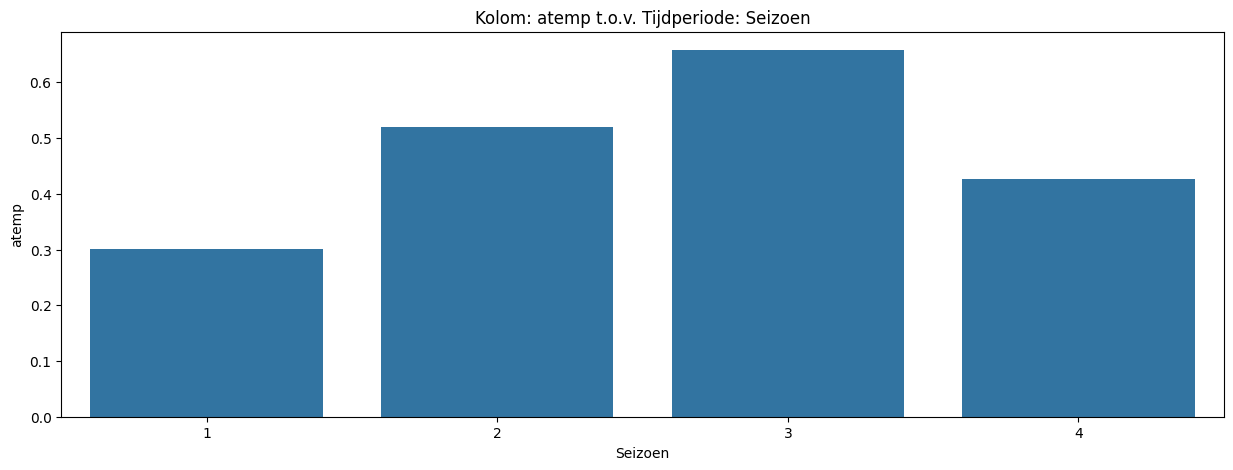

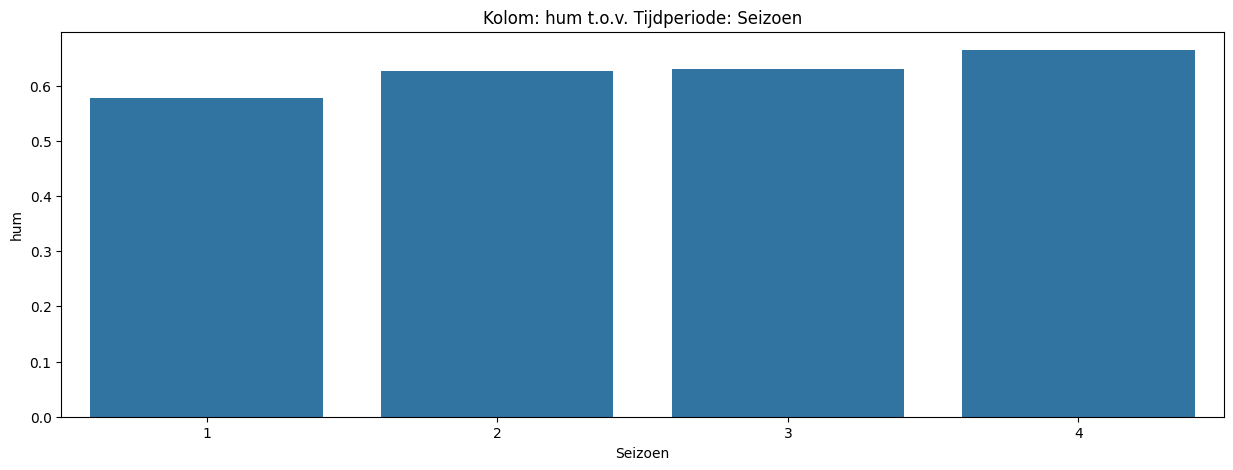

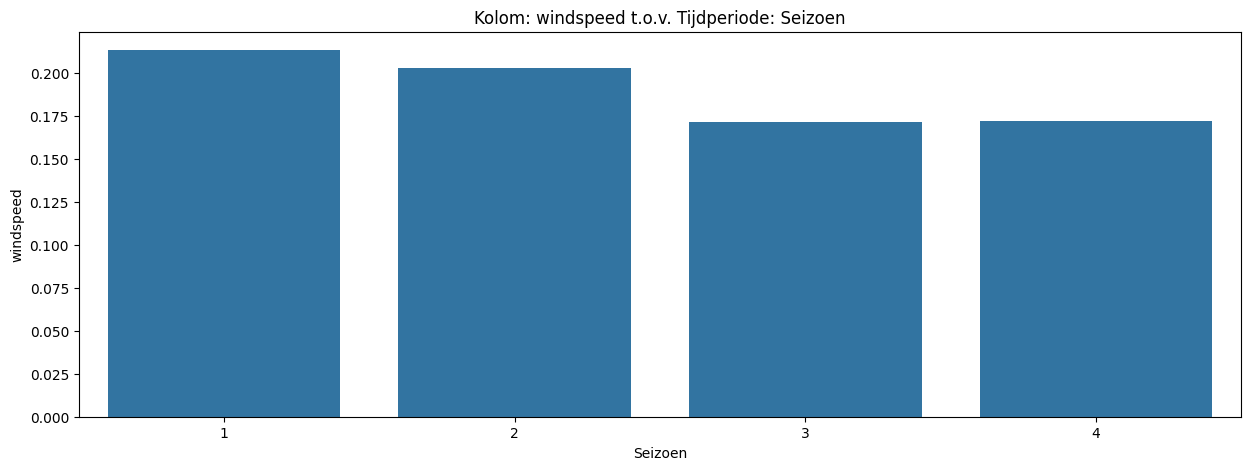

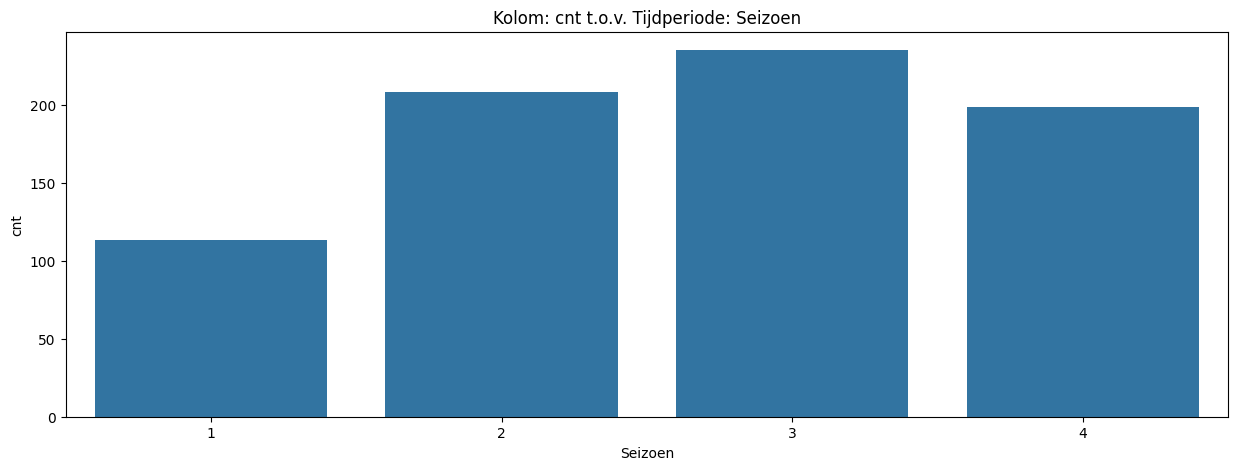

In [75]:
for col in kolommen:
    plt.subplots(figsize=(15,5))
    sns.barplot(data=df, x='Seizoen', y=col,
                errorbar=None)
    plt.title(f'Kolom: {col} t.o.v. Tijdperiode: Seizoen')
    plt.show()

Wat erg opvalt bij de seizoensverdeling is dat de maanden 2 en 3 (lente en zomer) het beste presteren in temperatuur en verhuuraantallen. Wat daarbij ook opvalt is dat in deze perioden de holiday parameter het laagste is.

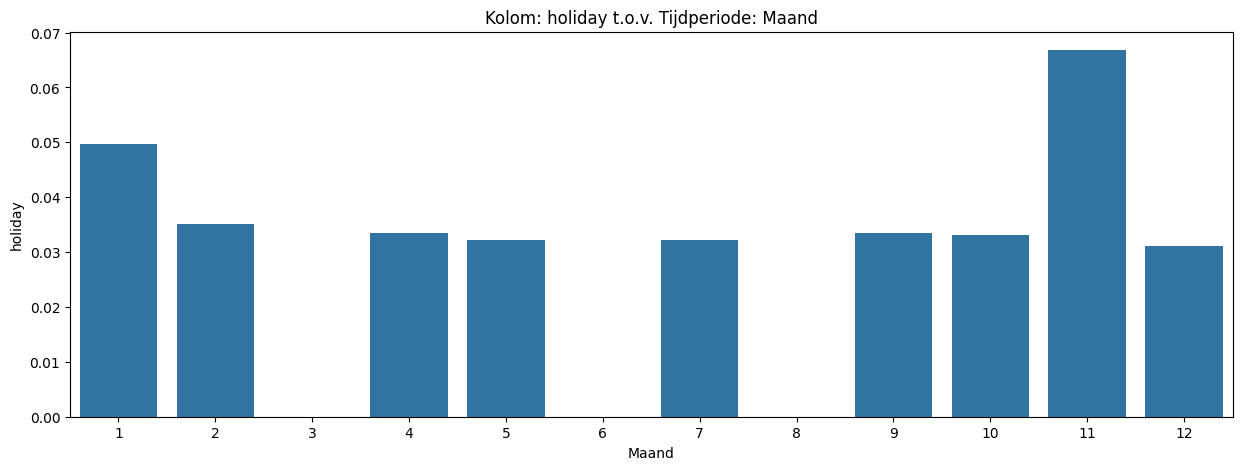

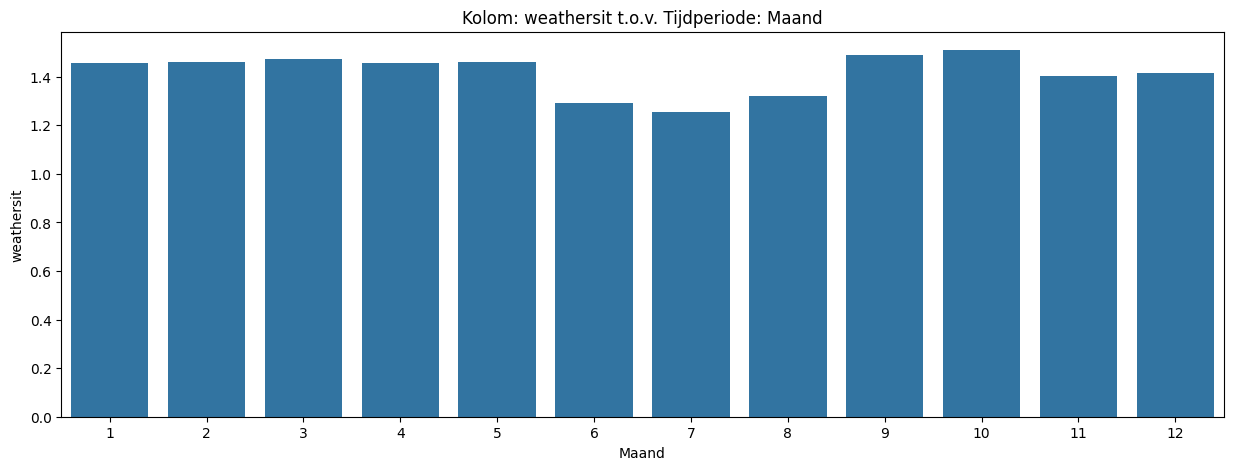

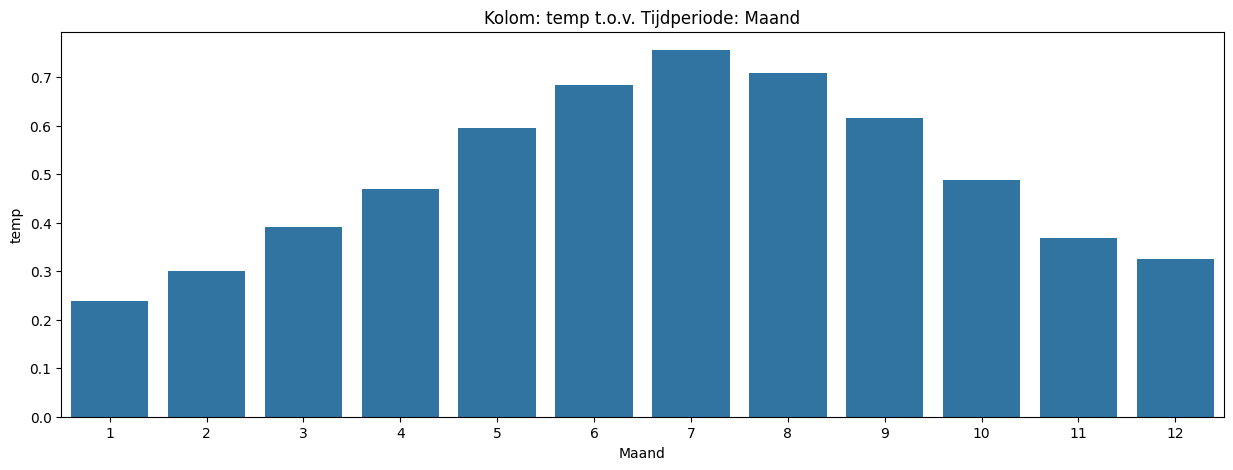

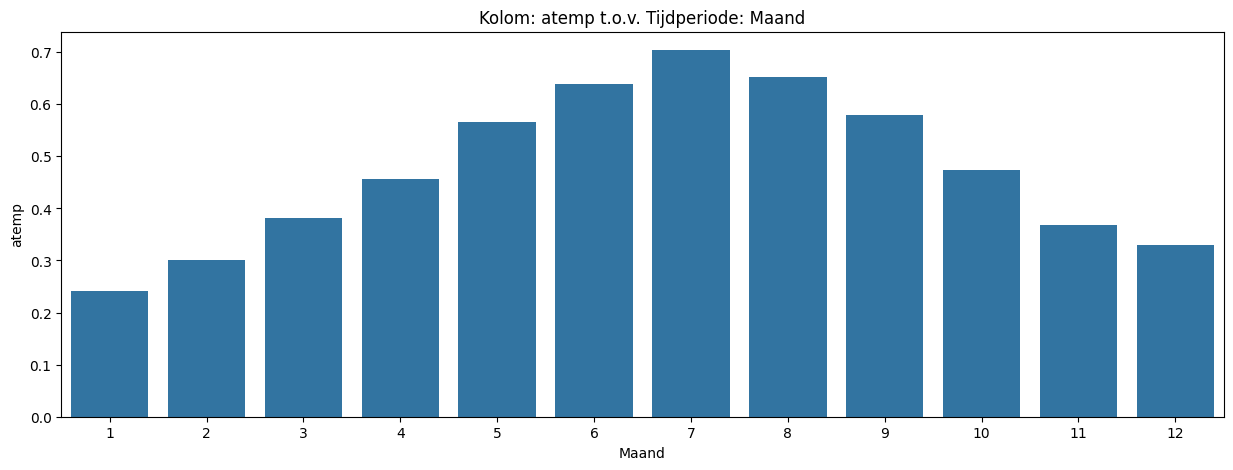

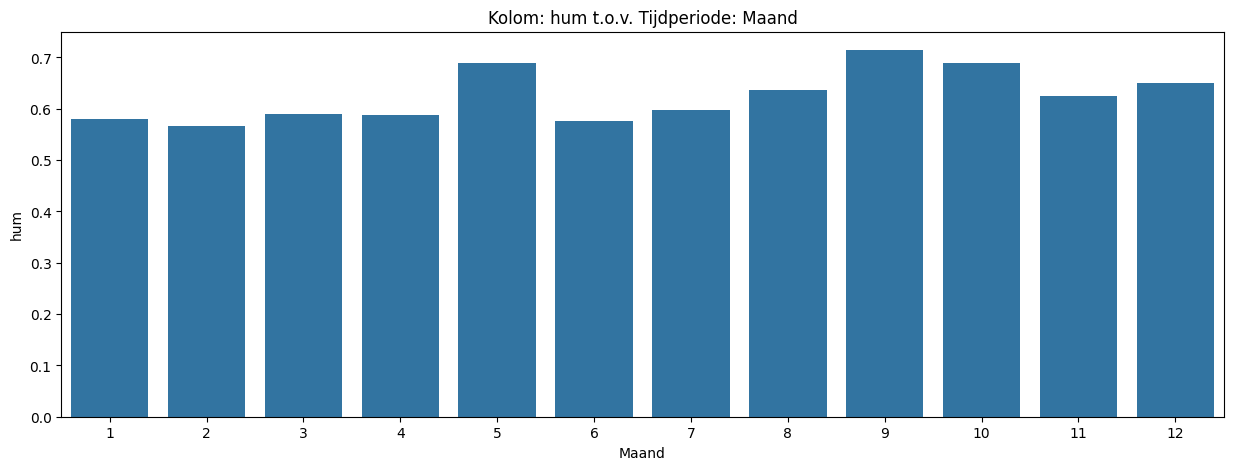

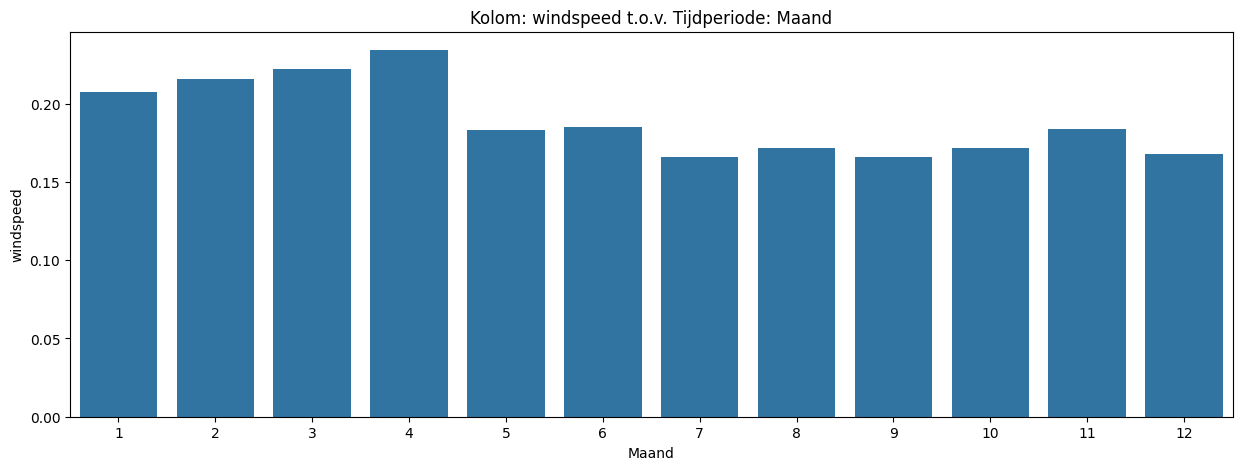

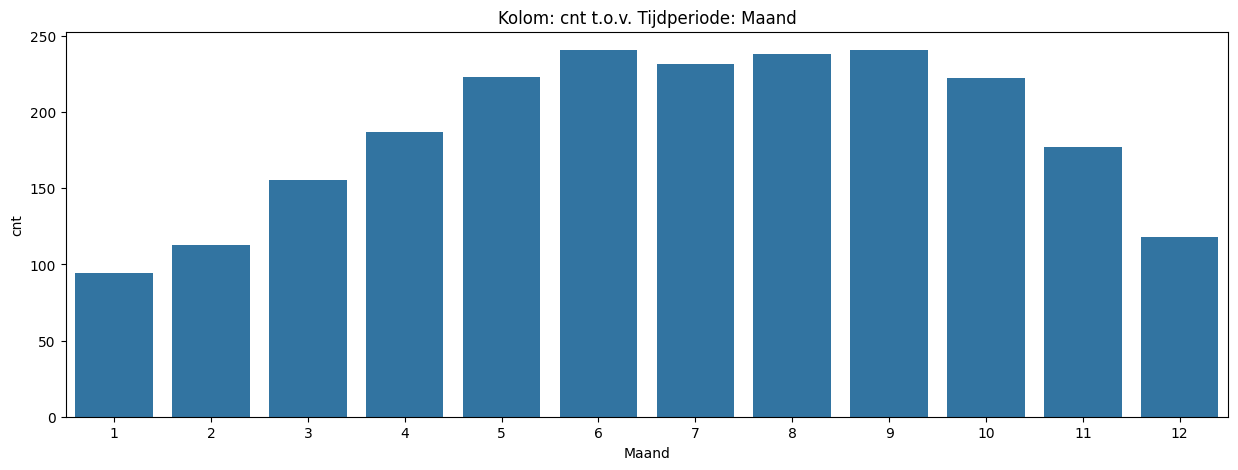

In [85]:
for col in kolommen:
    plt.subplots(figsize=(15,5))
    sns.barplot(data=df, x='Maand', y=col,
                errorbar=None)
    plt.title(f'Kolom: {col} t.o.v. Tijdperiode: Maand')
    plt.show()

Ook bij deze grafieken lijkt het erop dat de temperatuur het meeste invloed heeft op de verhuursaantallen. De andere factoren verschillen hier en daar, terwijl de temperatuur bijna gelijk oploopt en daalt met de hooogte van het verhuur.

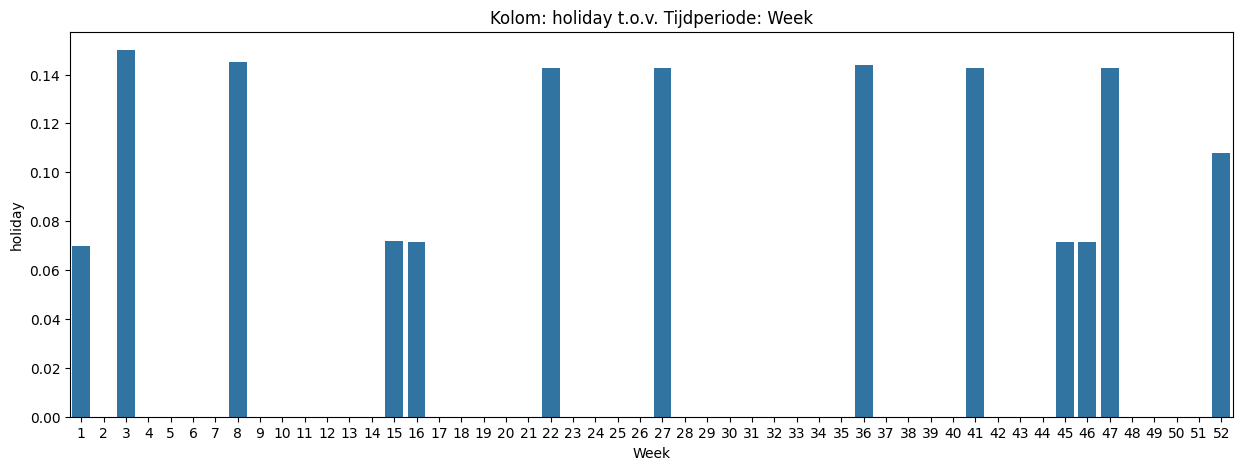

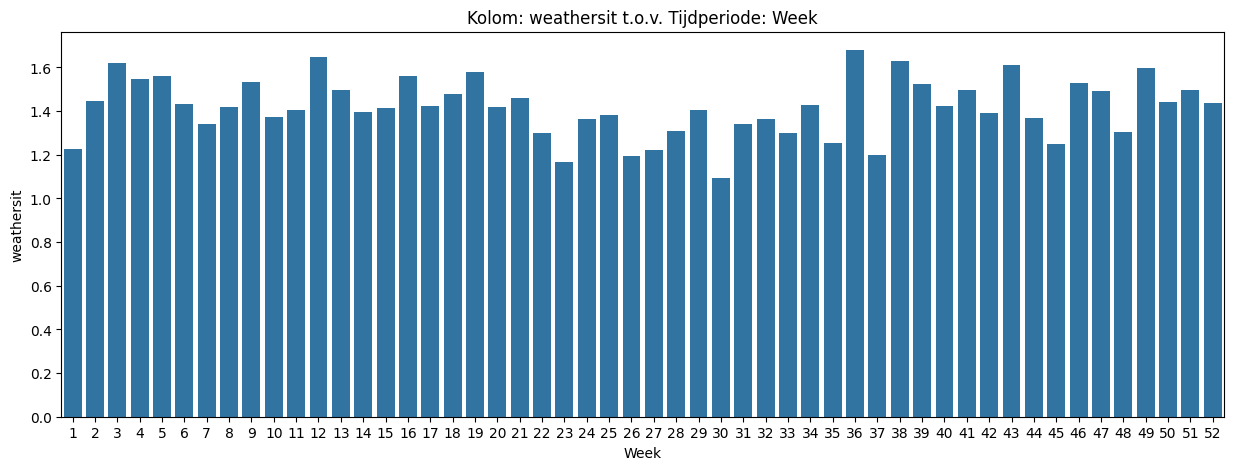

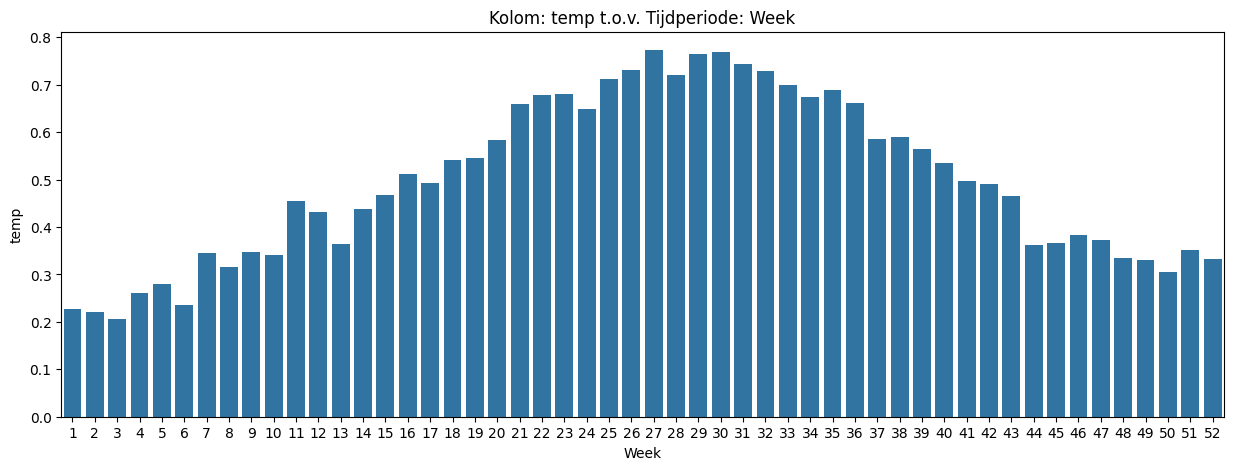

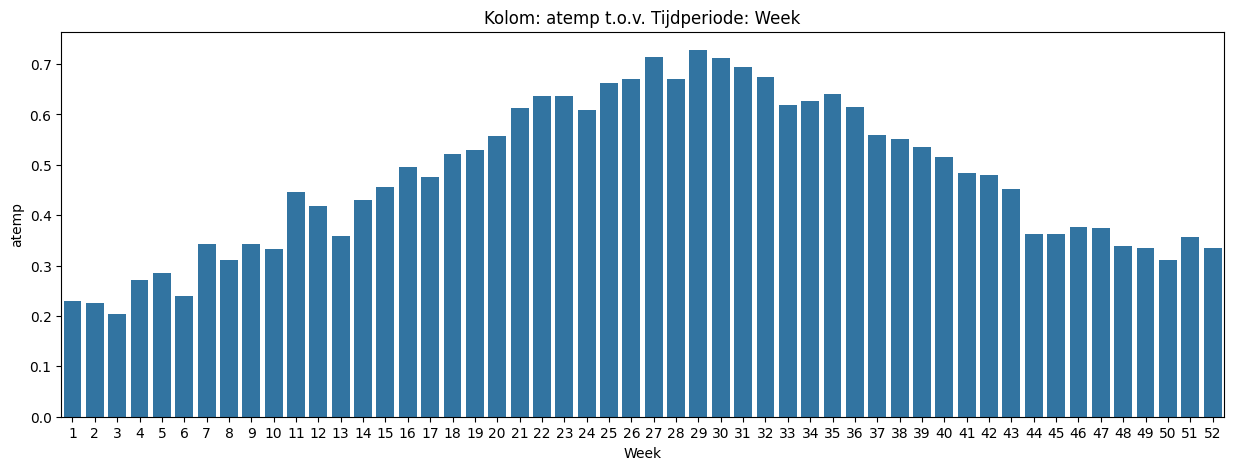

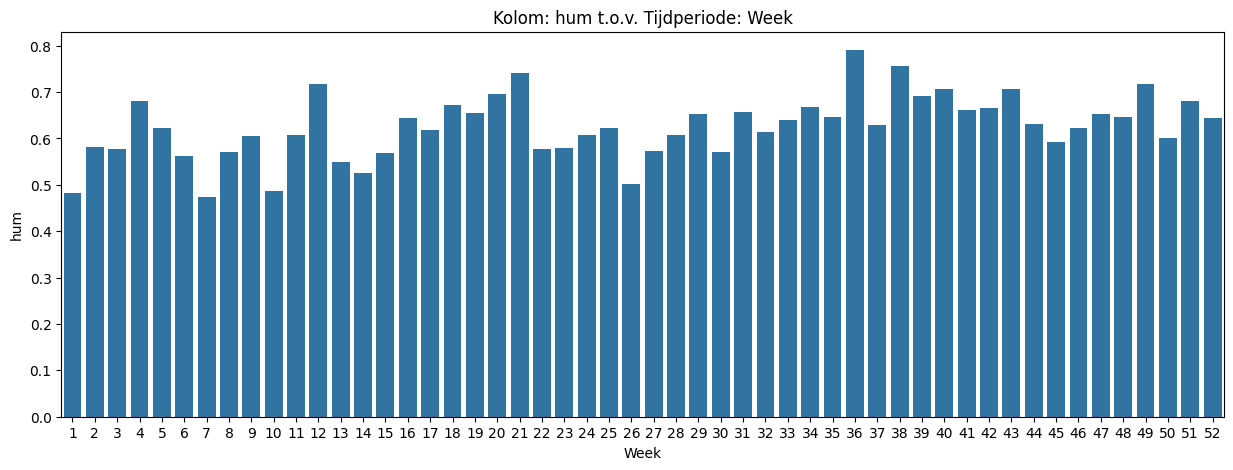

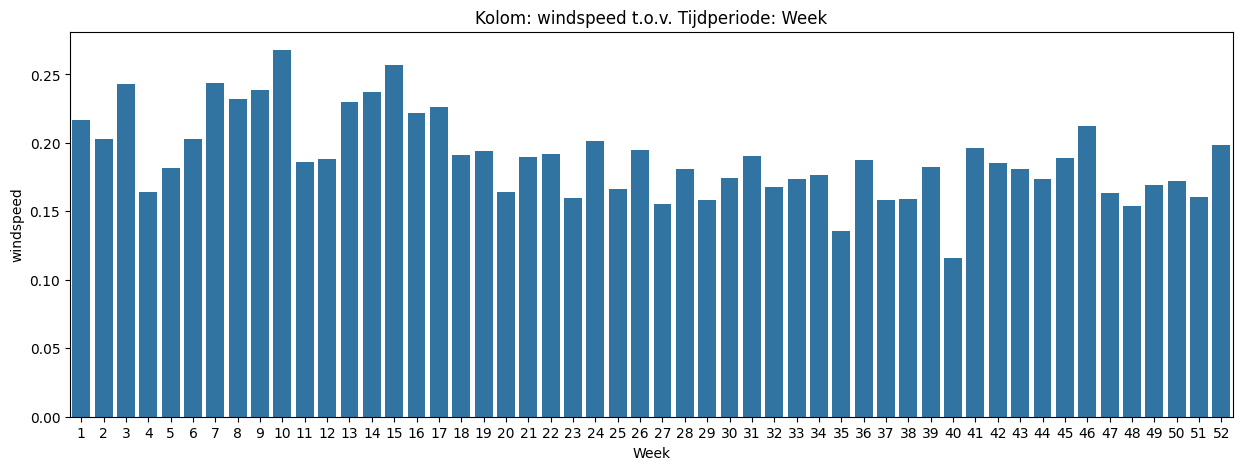

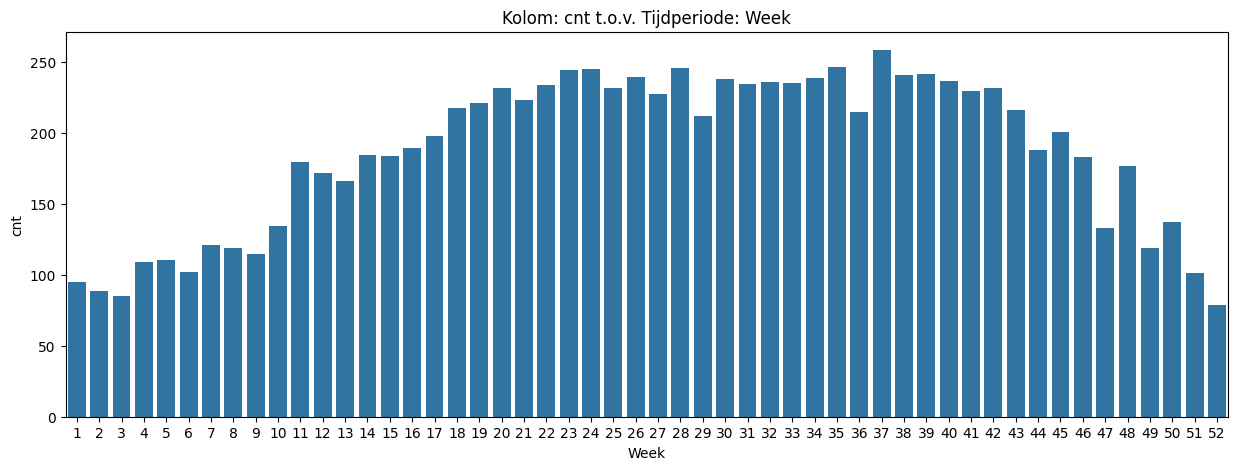

In [86]:
for col in kolommen:
    plt.subplots(figsize=(15,5))
    sns.barplot(data=df, x='Week', y=col,
                errorbar=None)
    plt.title(f'Kolom: {col} t.o.v. Tijdperiode: Week')
    plt.show()

Deze trend is ook bij de weekaantallen te merken. Ook tijdens weken met meer vakantie lijkt geen verhoging te zitten.

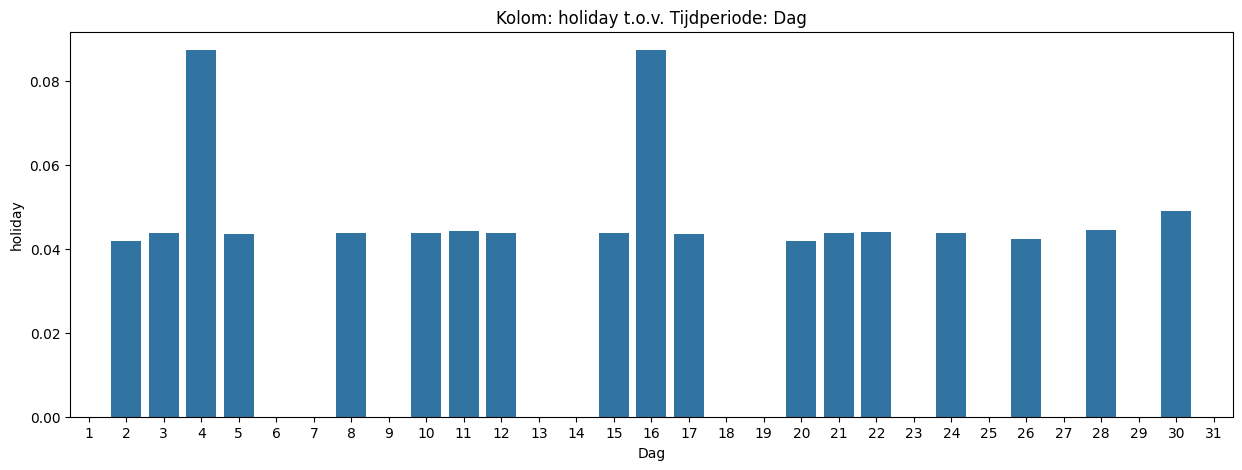

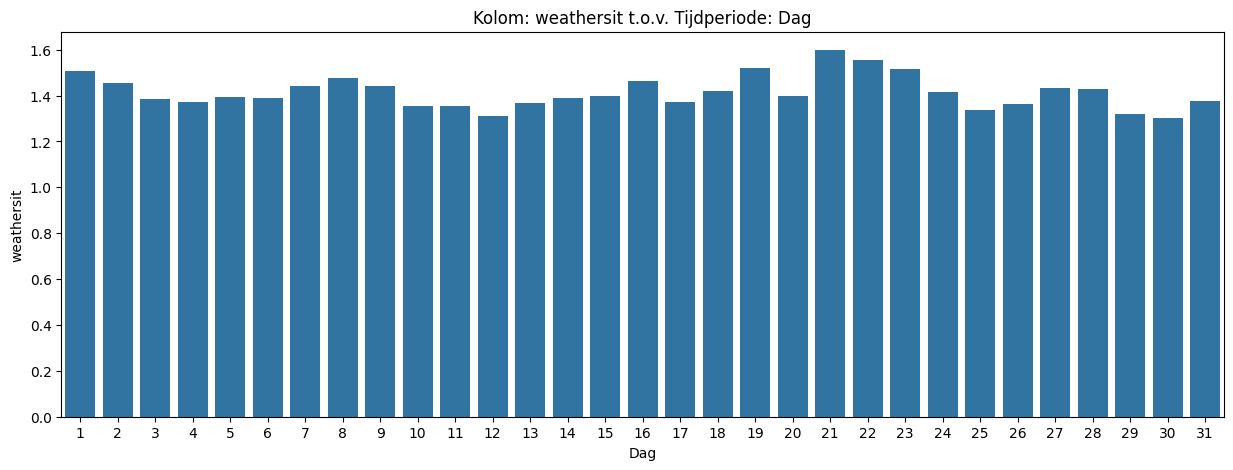

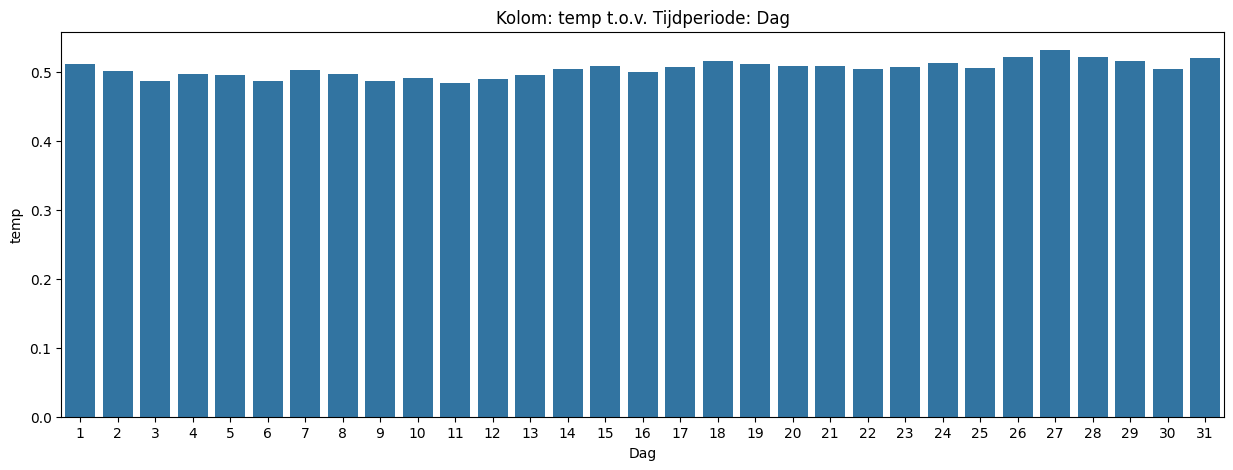

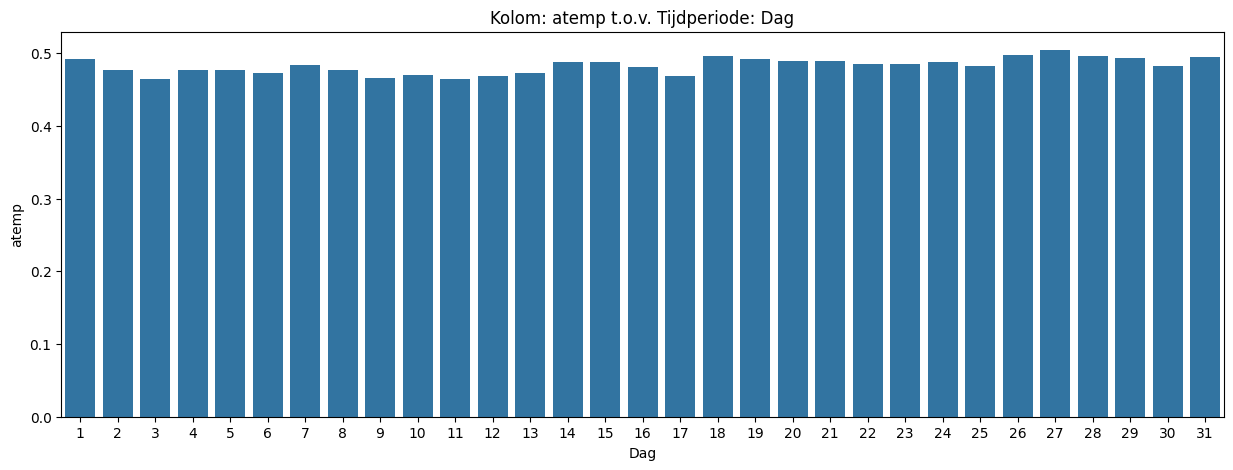

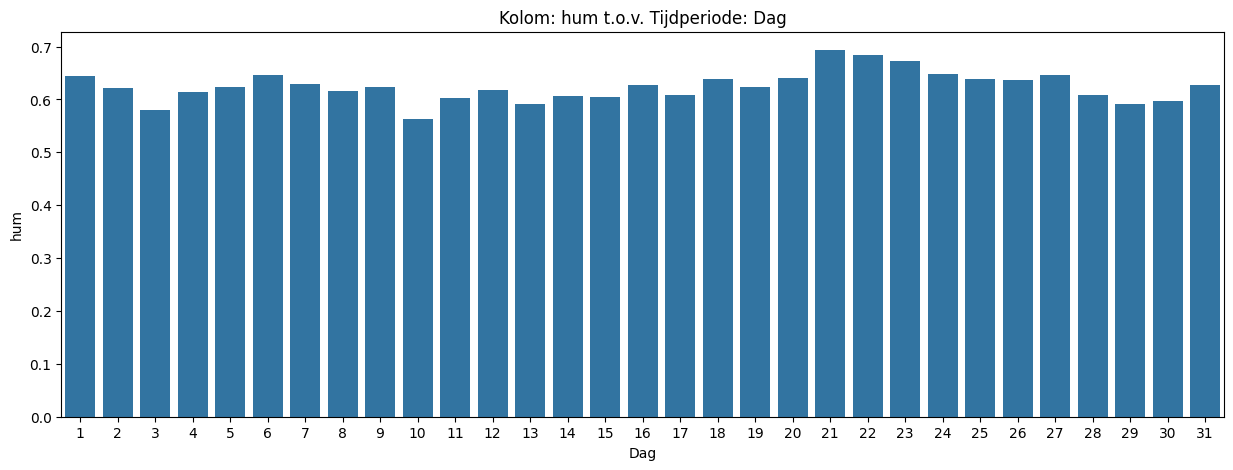

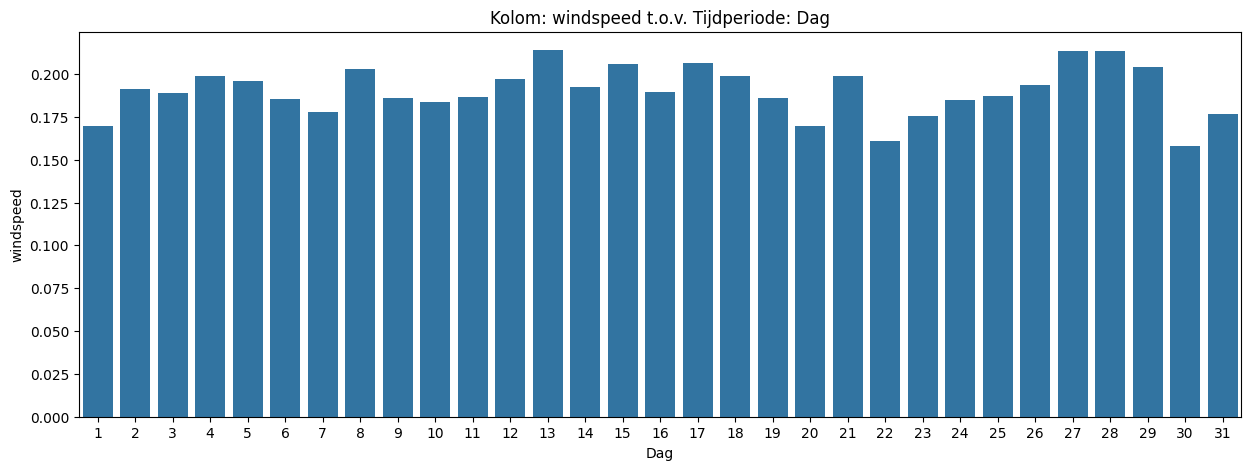

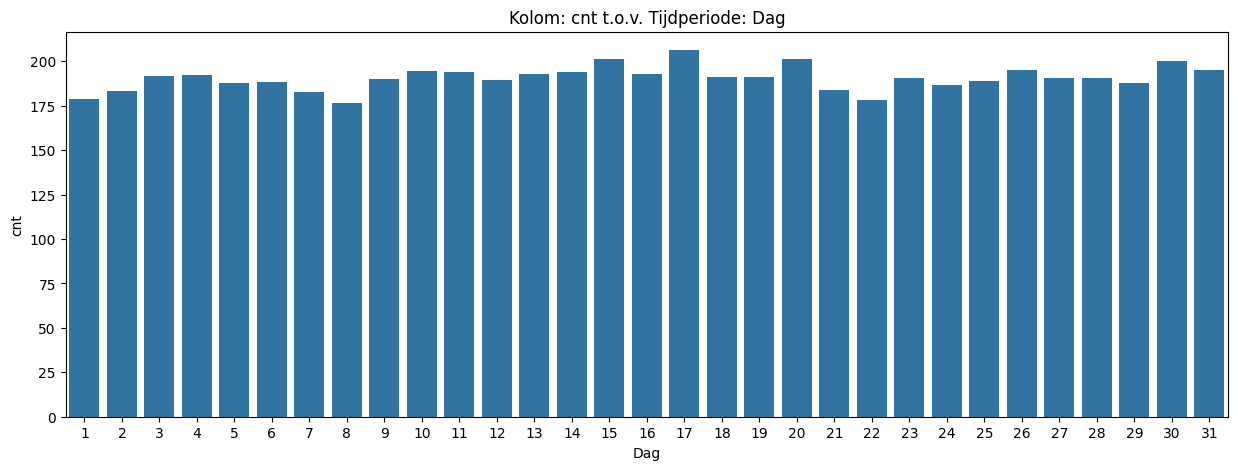

In [87]:
for col in kolommen:
    plt.subplots(figsize=(15,5))
    sns.barplot(data=df, x='Dag', y=col,
                errorbar=None)
    plt.title(f'Kolom: {col} t.o.v. Tijdperiode: Dag')
    plt.show()

Zoals verwacht is de dagelijkse hoeveelheid (gebaseerd op dagnummer van de maand) nagenoeg gelijk aan elkaar. Dit is logisch gezien dat de meeste maanden elke dag bevatten.

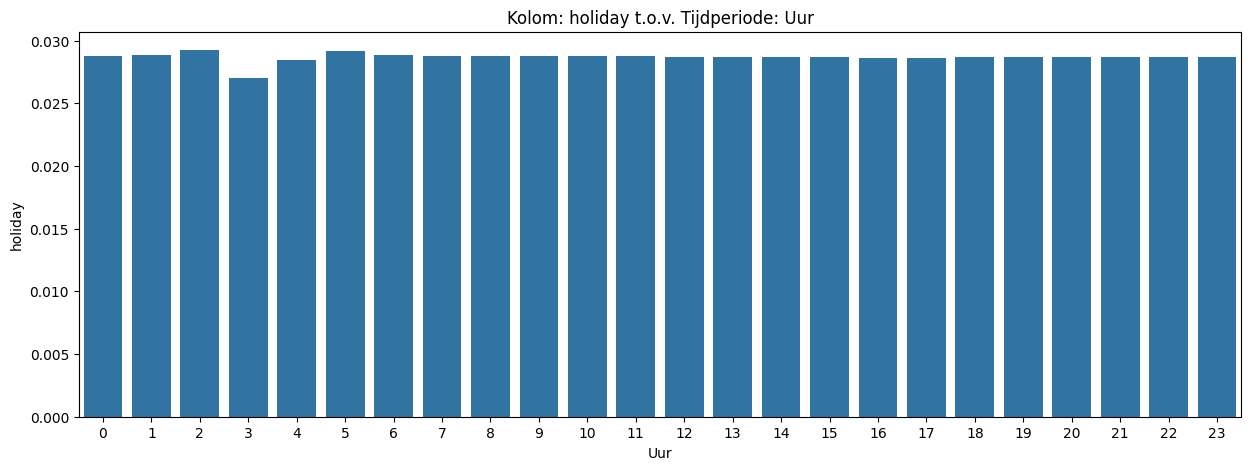

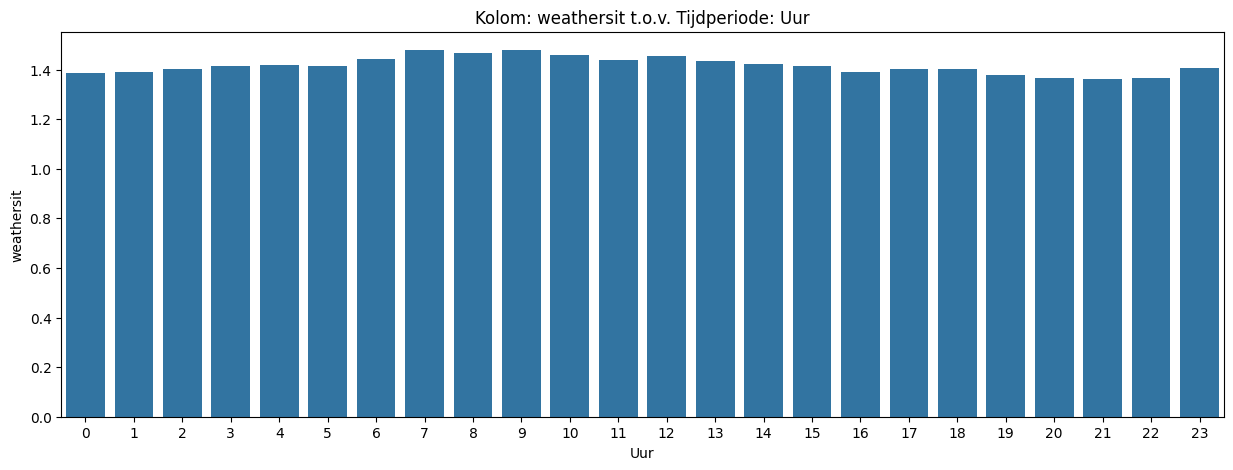

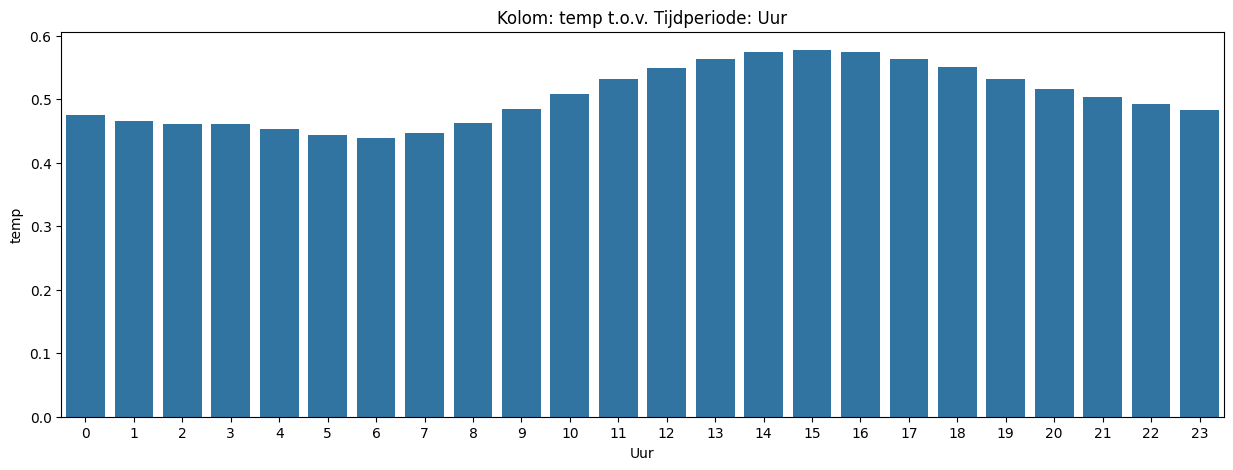

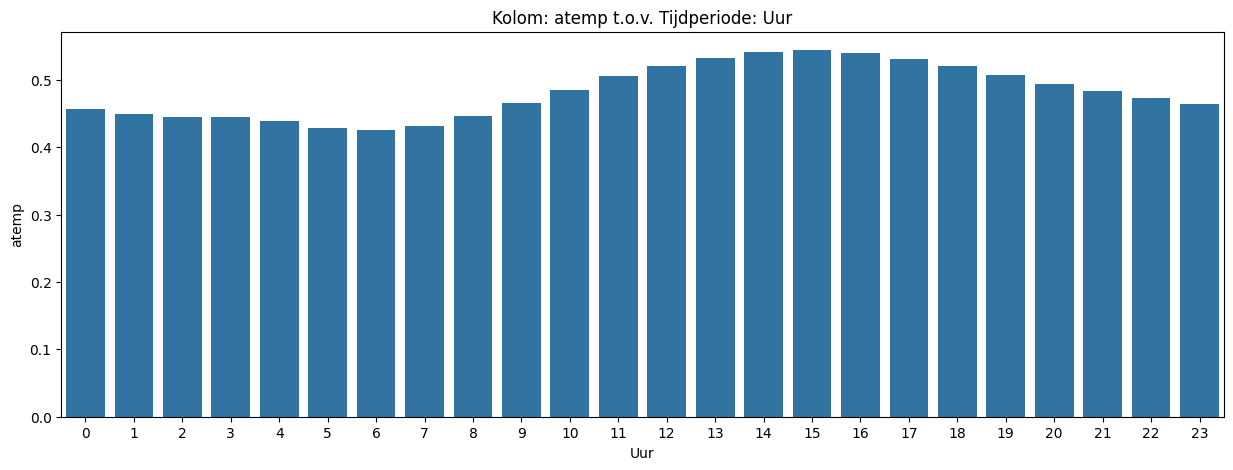

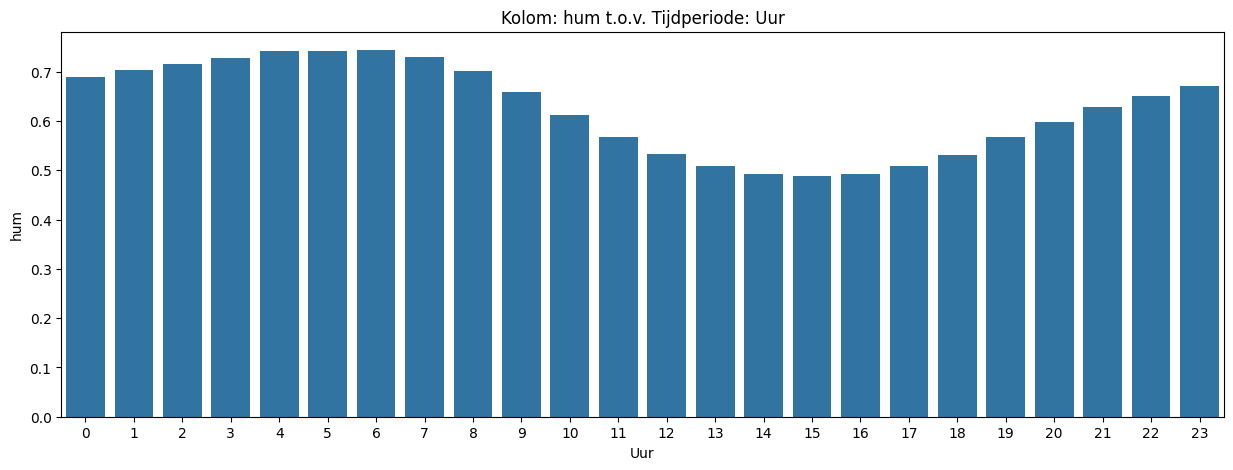

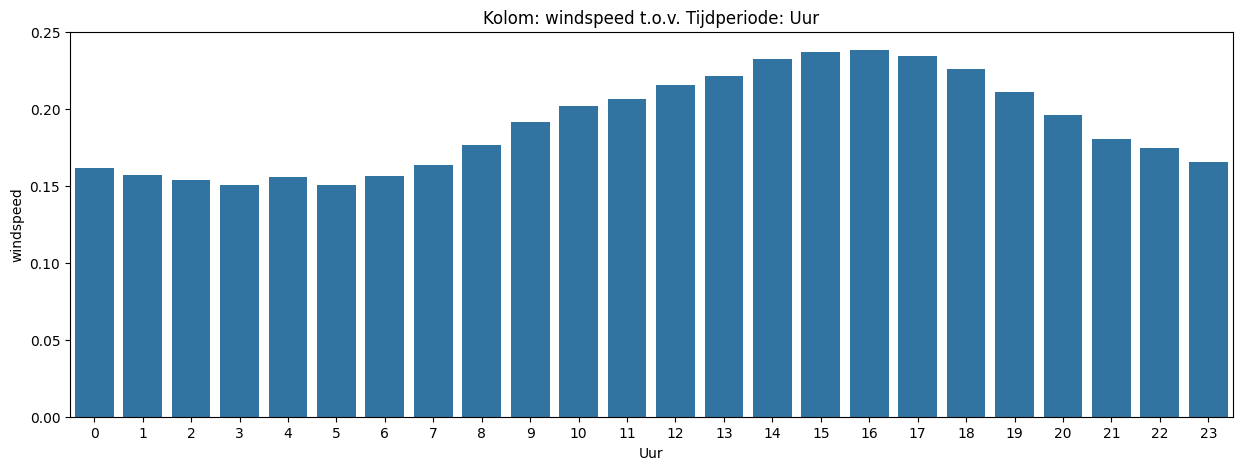

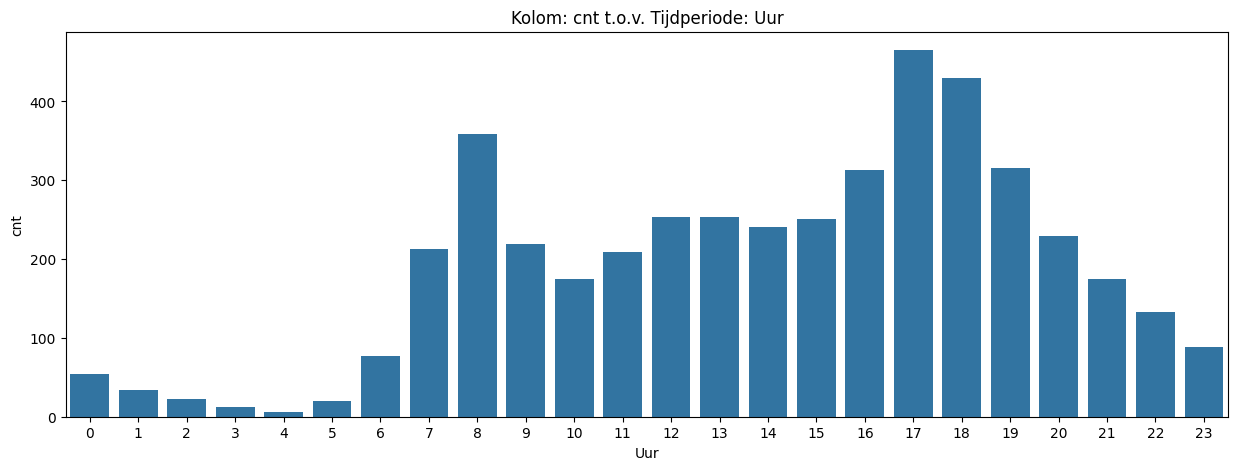

In [88]:
for col in kolommen:
    plt.subplots(figsize=(15,5))
    sns.barplot(data=df, x='Uur', y=col,
                errorbar=None)
    plt.title(f'Kolom: {col} t.o.v. Tijdperiode: Uur')
    plt.show()

Rond de uren 8 en 17 zijn de verhuuraantallen behoorlijk hoger dan bij de rest. Wat opvalt aan deze tijden is dat de temperatuur over het algemeen begint met stijgen om 8 uur en begint met weer te dalen rond 16 uur. Rond deze tijden gebeurt hetzelfde met de windsnelheid, dit was in vorige vormen van visualiseren niet te zien. Ook is de luchtvochtigheid juist weer andersom.

Alle verdere visualisaties komen overeen met wat er in de eerste set was gevonden. Bij betere weersituaties willen mensen meer gebruikmaken van het verhuurde product.